In [1]:
import os
import sys
import time
import random
import numpy as np
# import pandas as pd
# import keras
import tensorflow as tf
import pickle

import skimage
import skimage.io
import skimage.transform
# from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from PIL import Image
import scipy
from sklearn.utils import shuffle

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
def leaky_relu(features, alpha=0.2, name=None):
    """Compute the Leaky ReLU activation function.
    "Rectifier Nonlinearities Improve Neural Network Acoustic Models"
    AL Maas, AY Hannun, AY Ng - Proc. ICML, 2013
    http://web.stanford.edu/~awni/papers/relu_hybrid_icml2013_final.pdf
    Args:
    features: A `Tensor` representing preactivation values.
    alpha: Slope of the activation function at x < 0.
    name: A name for the operation (optional).
    Returns:
    The activation value.
    """
    with ops.name_scope(name, "LeakyRelu", [features, alpha]):
        features = ops.convert_to_tensor(features, name="features")
        alpha = ops.convert_to_tensor(alpha, name="alpha")
        return math_ops.maximum(alpha * features, features)

## argument setting

In [2]:
random.seed(1)
np.random.seed(1)
tf.set_random_seed(1)

# def init():
#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     session = tf.Session(config=config)
#     keras.backend.tensorflow_backend.set_session(session)
# init()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

img_path = './data'
len_img_all = 33431
condition = True
toy_test = False
load_data = True
if toy_test :
    len_img_all = 512
    load_data = False
tag_img_only = False
batch_size = 32
iteration = 100000
D_ITER = 1
G_ITER = 1
d_lda = 10

output_str = 'gan8'
load_model = False

In [3]:
class GAN_no_condition(object):
    def __init__(self) :
        self.lr = 0.0001
        self.momentum = 0.5
        self.bs = batch_size # batch size is m of paper
        self.epoch = 10000
        self.hair_n = 13
        self.eyes_n = 12
        self.lda = d_lda
        self.epsilon = 0.5
        self.activation = tf.nn.relu
        
    def build_G_net(self) :
        with tf.variable_scope('G') as g_scope:
#             self.G_in_hair = tf.placeholder(tf.int32, shape=[None])
#             self.G_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.G_in_noise = tf.placeholder(tf.float32, shape=[None,100])
#             self.G_in_noise = tf.distributions.Normal(loc=0., scale=1.).sample([self.bs,100])
            
#             G_H_onehot = tf.one_hot(self.G_in_hair, self.hair_n)
#             G_E_onehot = tf.one_hot(self.G_in_eyes, self.eyes_n)
#             g = tf.concat([G_H_onehot, G_E_onehot, self.G_in_noise], axis=1)
            
#             g = keras.layers.Dense(4*4*1024, activation='linear')(g)
            g = tf.layers.dense(self.G_in_noise,4*4*1024,activation=None)
            g = tf.reshape(g,(-1,4,4,1024))
#             g = self.activation(g)
            
            g = tf.layers.conv2d_transpose(g, filters=512, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=256, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=128, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            self.g = tf.layers.conv2d_transpose(g, filters=3, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            
            ####
#             d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), 
#                                  padding='same', activation=self.activation, name='d_c1', reuse=None)
#             d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), 
#                                  padding='same', activation=self.activation, name='d_c2', reuse=None)
#             print (d)
            
        
    def build_D_net(self) :
        
        '''
        # This is a logistic regression
        x = tf.layers.Input(shape=(32,))
        y = tf.layers.Dense(16, activation='softmax')(x)
        network = tf.layers.Network(x, y)
        '''
#         with tf.variable_scope('D') as d_scope:
#         tf.get_variable_scope(),reuse=True
        with tf.variable_scope('D') as d_scope:
#             self.y_D = tf.placeholder(tf.float32, shape=[None,1])
            
#             self.D_in_hair_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_eyes_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_img_right = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
#             #這裡要放亂搭配的placeholder還是直接由tf生成
#             #放placeholder
#             self.D_in_hair_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_eyes_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_img_right = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
#             self.D_in_hair = tf.concat([self.D_in_hair_right, self.G_in_hair] ,axis=0)
#             self.D_in_eyes = tf.concat([self.D_in_eyes_right, self.G_in_eyes], axis=0)
#             self.D_in_img = tf.concat([self.D_in_img_right, self.g], axis=0)

#             d_scope.reuse_variables()

            ### include right and fake1
#             self.D_in_hair = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.D_in_img = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
#             D_H_onehot = tf.one_hot(self.D_in_hair, self.hair_n)
#             D_E_onehot = tf.one_hot(self.D_in_eyes, self.eyes_n)
#             D_H_onehot = tf.reshape(tf.one_hot(self.D_in_hair, self.hair_n), shape=[-1,self.hair_n])
#             D_E_onehot = tf.reshape(tf.one_hot(self.D_in_eyes, self.eyes_n), shape=[-1,self.eyes_n])
            
            
#             self.D_in_hair_right = D_H_onehot[:self.bs]
#             self.D_in_eyes_right = D_E_onehot[:self.bs]
            self.D_in_img_right = self.D_in_img[:self.bs]
            
#             self.D_in_hair_fake = D_H_onehot[self.bs:]
#             self.D_in_eyes_fake = D_E_onehot[self.bs:]
            self.D_in_img_fake = self.D_in_img[self.bs:]
            
#             self.D_in_hair_right = D_H_onehot
#             self.D_in_eyes_right = D_E_onehot
#             self.D_in_img_right = self.D_in_img
            
#             self.D_in_hair_fake = D_H_onehot[self.bs:]
#             self.D_in_eyes_fake = D_E_onehot[self.bs:]
#             self.D_in_img_fake = self.D_in_img[self.bs:]
            
            use_epsilon_uniform = 1
            if use_epsilon_uniform :
                epsilon = np.random.random_sample()
#                 epsilon_hair = tf.random_uniform(shape=[self.bs,self.hair_n])
#                 epsilon_eyes = tf.random_uniform(shape=[self.bs,self.eyes_n])
#                 epsilon_img = tf.random_uniform(shape=[self.bs,64,64,3])
#                 self.D_x_hat_hair = epsilon*self.D_in_hair_right + (1-epsilon)*self.D_in_hair_fake
#                 self.D_x_hat_eyes = epsilon*self.D_in_eyes_right + (1-epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = epsilon*self.D_in_img_right + (1-epsilon)*self.D_in_img_fake
            else :
#                 self.D_x_hat_hair = self.epsilon*self.D_in_hair_right + (1-self.epsilon)*self.D_in_hair_fake
#                 self.D_x_hat_eyes = self.epsilon*self.D_in_eyes_right + (1-self.epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = self.epsilon*self.D_in_img_right + (1-self.epsilon)*self.D_in_img_fake
                
            self.D_img = tf.concat([self.D_in_img_right,self.D_in_img_fake,self.D_x_hat_img], axis=0)
#             self.D_hair = tf.concat([self.D_in_hair_right,self.D_in_hair_fake,self.D_x_hat_hair], axis=0)
#             self.D_eyes = tf.concat([self.D_in_eyes_right,self.D_in_eyes_fake,self.D_x_hat_eyes], axis=0)
            
            d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c1', reuse=None)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c2', reuse=None)
            print (d)
            d = tf.layers.conv2d(d, filters=512, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c3', reuse=None)
            d = tf.layers.conv2d(d, filters=1024, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c4', reuse=None)
            
#             D_tag_in = tf.concat([self.D_hair, self.D_eyes], axis=1)
#             D_tag_in = tf.layers.dense(D_tag_in,4*4*1024,activation=self.activation, name='d_d1', reuse=None)
#             D_tag_in = tf.reshape(D_tag_in,(-1,4,4,1024))
            
#             d = tf.concat([d, D_tag_in], axis=3)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', reuse=None)
#             d = tf.layers.flatten(d)
            d = tf.reshape(d, [-1, 4*4*256]) 
            self.d_temp = tf.layers.dense(d, 1 ,activation=None, name='d_d2', reuse=None)
            
            self.d_right, self.d_fake, self.d_x_hat = tf.split(self.d_temp, num_or_size_splits=3, axis=0)
#             self.d_right, self.d_fake_temp = tf.split(self.d_temp, num_or_size_splits=2, axis=0)
#             self.d_fake, self.d_x_hat = tf.split(self.d_fake_temp, num_or_size_splits=2, axis=0)
            
#             ### wgan loss
#             self.d = tf.concat([self.d_right, self.d_fake], axis=0)
            
            ### gradient penalty
#             gradient_temp = tf.gradients(self.d_x_hat,[self.D_x_hat_img,self.D_x_hat_hair,self.D_x_hat_eyes])
            gradient_temp = tf.gradients(self.d_x_hat,self.D_x_hat_img)
            print (gradient_temp)
#             self.gradient_penalty = tf.maximum(tf.constant(0.0, shape=[self.bs,1]), tf.sqrt(tf.square(gradient_temp)) - tf.constant(1.0, shape=[self.bs,1]))
            self.gradient_penalty = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_temp), axis=1)) - 1)
            self.gradient_penalty = self.lda * tf.reduce_mean(self.gradient_penalty)
            
            ### final loss
            self.d_loss = - (tf.reduce_mean(self.d_right) - tf.reduce_mean(self.d_fake) - self.gradient_penalty)
            
            
            self.d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"D/")
            self.d_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_train_vars)
            
            ###
            ### G loss
            ###
#             self.G_D_in_hair = self.G_in_hair
#             self.G_D_in_eyes = self.G_in_eyes
            self.G_D_in_img = self.g
            
#             self.G_D_eyes = tf.one_hot(self.G_D_in_eyes, self.eyes_n)
#             self.G_D_hair = tf.one_hot(self.G_D_in_hair, self.hair_n)
            
            g_d = tf.layers.conv2d(self.G_D_in_img, filters=128, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c1', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c2', reuse=True)
            print (d)
            g_d = tf.layers.conv2d(g_d, filters=512, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c3', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=1024, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c4', reuse=True)
            
#             G_D_tag_in = tf.concat([self.G_D_hair, self.G_D_eyes], axis=1)
#             G_D_tag_in = tf.layers.dense(G_D_tag_in,4*4*1024,activation=self.activation, name='d_d1', reuse=True)
#             G_D_tag_in = tf.reshape(G_D_tag_in,(-1,4,4,1024))
            
#             g_d = tf.concat([g_d, G_D_tag_in], axis=3)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', reuse=True)
#             d = tf.layers.flatten(d)
            g_d = tf.reshape(g_d, [-1, 4*4*256]) 
            self.g_d_temp = tf.layers.dense(g_d, 1 ,activation=None, name='d_d2', reuse=True)
            
            self.gd_loss = - tf.reduce_mean(self.g_d_temp)
            
            self.gd_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G/")
            print (self.gd_train_vars)
            self.gd_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.gd_loss, var_list=self.gd_train_vars)
            
    def build_net(self) :
        self.build_G_net()
        self.build_D_net()
#         first = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G")
#         print (first)
#         lst_G_trainable = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G/')
#         print (lst_G_trainable)
#         lst = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G_D/')
#         print (lst)
#         lst_D_trainable = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D/')
#         print (lst)
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        tf.summary.FileWriter("logs/", self.sess.graph)


In [4]:
class GAN(object):
    def __init__(self) :
        self.lr = 0.0001
        self.momentum = 0.5
        self.bs = batch_size # batch size is m of paper
        self.epoch = 10000
        self.hair_n = 13
        self.eyes_n = 12
        self.lda = 10
        self.epsilon = 0.5
        self.activation = tf.nn.relu
        
    def build_G_net(self) :
        with tf.variable_scope('G') as g_scope:
            self.G_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.G_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.G_in_noise = tf.placeholder(tf.float32, shape=[None,100])
#             self.G_in_noise = tf.distributions.Normal(loc=0., scale=1.).sample([self.bs,100])
            
            G_H_onehot = tf.one_hot(self.G_in_hair, self.hair_n)
            G_E_onehot = tf.one_hot(self.G_in_eyes, self.eyes_n)
            g = tf.concat([G_H_onehot, G_E_onehot, self.G_in_noise], axis=1)
            
#             g = keras.layers.Dense(4*4*1024, activation='linear')(g)
            g = tf.layers.dense(g,4*4*1024,activation=None)
            g = tf.reshape(g,(-1,4,4,1024))
#             g = self.activation(g)
            
            g = tf.layers.conv2d_transpose(g, filters=512, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=256, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=128, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            self.g = tf.layers.conv2d_transpose(g, filters=3, kernel_size=(5,5), strides=(2,2), 
                                           padding='same', activation=self.activation)
            
            
        
    def build_D_net(self) :
        
        with tf.variable_scope('D') as d_scope:

            self.D_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.D_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.D_in_img = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
            D_H_onehot = tf.one_hot(self.D_in_hair, self.hair_n)
            D_E_onehot = tf.one_hot(self.D_in_eyes, self.eyes_n)
            
            
            self.D_in_hair_right = D_H_onehot[:self.bs]
            self.D_in_eyes_right = D_E_onehot[:self.bs]
            self.D_in_img_right = self.D_in_img[:self.bs]
            
            self.D_in_hair_fake = D_H_onehot[self.bs:]
            self.D_in_eyes_fake = D_E_onehot[self.bs:]
            self.D_in_img_fake = self.D_in_img[self.bs:]
            
            use_epsilon_uniform = 1
            if use_epsilon_uniform :
                epsilon = np.random.random_sample()

                self.D_x_hat_hair = epsilon*self.D_in_hair_right + (1-epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = epsilon*self.D_in_eyes_right + (1-epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = epsilon*self.D_in_img_right + (1-epsilon)*self.D_in_img_fake
            else :
                self.D_x_hat_hair = self.epsilon*self.D_in_hair_right + (1-self.epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = self.epsilon*self.D_in_eyes_right + (1-self.epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = self.epsilon*self.D_in_img_right + (1-self.epsilon)*self.D_in_img_fake
                
            self.D_img = tf.concat([self.D_in_img_right,self.D_in_img_fake,self.D_x_hat_img], axis=0)
            self.D_hair = tf.concat([self.D_in_hair_right,self.D_in_hair_fake,self.D_x_hat_hair], axis=0)
            self.D_eyes = tf.concat([self.D_in_eyes_right,self.D_in_eyes_fake,self.D_x_hat_eyes], axis=0)
            
            d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c1', reuse=None)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c2', reuse=None)
            d = tf.layers.conv2d(d, filters=512, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c3', reuse=None)
            d = tf.layers.conv2d(d, filters=1024, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c4', reuse=None)
            
            D_tag_in = tf.concat([self.D_hair, self.D_eyes], axis=1)
            D_tag_in = tf.layers.dense(D_tag_in,4*4*1024,activation=self.activation, name='d_d1', reuse=None)
            D_tag_in = tf.reshape(D_tag_in,(-1,4,4,1024))
            
            d = tf.concat([d, D_tag_in], axis=3)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', reuse=None)
#             d = tf.layers.flatten(d)
            d = tf.reshape(d, [-1, 4*4*256]) 
            self.d_temp = tf.layers.dense(d, 1 ,activation=None, name='d_d2', reuse=None)
        
            self.d_right, self.d_fake_temp = tf.split(self.d_temp, num_or_size_splits=2, axis=0)
            self.d_fake, self.d_x_hat = tf.split(self.d_fake_temp, num_or_size_splits=2, axis=0)
#             ### wgan loss
#             self.d = tf.concat([self.d_right, self.d_fake], axis=0)
            
            ### gradient penalty
#             gradient_temp = tf.gradients(self.d_x_hat,[self.D_x_hat_img,self.D_x_hat_hair,self.D_x_hat_eyes])
            gradient_temp = tf.gradients(self.d_x_hat,self.D_x_hat_img)
#             self.gradient_penalty = tf.maximum(tf.constant(0.0, shape=[self.bs,1]), tf.sqrt(tf.square(gradient_temp)) - tf.constant(1.0, shape=[self.bs,1]))
            self.gradient_penalty = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_temp), axis=1)) - 1)
            self.gradient_penalty = self.lda * tf.reduce_mean(self.gradient_penalty)
            
            ### final loss
            self.d_loss = -(tf.reduce_mean(self.d_right) - tf.reduce_mean(self.d_fake) - self.gradient_penalty)
            
            
            self.d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"D/")
            self.d_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_train_vars)
            
            ###
            ### G loss
            ###
            self.G_D_in_hair = self.G_in_hair
            self.G_D_in_eyes = self.G_in_eyes
            self.G_D_in_img = self.g
            
            self.G_D_eyes = tf.one_hot(self.G_D_in_eyes, self.eyes_n)
            self.G_D_hair = tf.one_hot(self.G_D_in_hair, self.hair_n)
            
            g_d = tf.layers.conv2d(self.G_D_in_img, filters=128, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c1', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c2', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=512, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c3', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=1024, kernel_size=(5,5), strides=(2,2), 
                                 padding='same', activation=self.activation, name='d_c4', reuse=True)
            
            G_D_tag_in = tf.concat([self.G_D_hair, self.G_D_eyes], axis=1)
            G_D_tag_in = tf.layers.dense(G_D_tag_in,4*4*1024,activation=self.activation, name='d_d1', reuse=True)
            G_D_tag_in = tf.reshape(G_D_tag_in,(-1,4,4,1024))
            
            g_d = tf.concat([g_d, G_D_tag_in], axis=3)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', reuse=True)
#             d = tf.layers.flatten(d)
            g_d = tf.reshape(g_d, [-1, 4*4*256]) 
            self.g_d_temp = tf.layers.dense(g_d, 1 ,activation=None, name='d_d2', reuse=True)
            
            self.gd_loss = - tf.reduce_mean(self.g_d_temp)
            
            self.gd_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G/")
            self.gd_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.gd_loss, var_list=self.gd_train_vars)
            
    def build_net(self) :
        self.build_G_net()
        self.build_D_net()
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        tf.summary.FileWriter("logs/", self.sess.graph)
        
        if load_model:
            #you can load your model here
            k = 16
            output_str = 'condition_oneone'
            print('loading trained model')
            self.saver.restore(self.sess, './model_tf/model_{}_{}.ckpt'.format(output_str, k))
            print ('loading model finished...')


In [5]:
class GAN_leaky_relu(object):
    def __init__(self) :
        self.lr = 0.0001
        self.momentum = 0.5
        self.bs = batch_size # batch size is m of paper
        self.epoch = 10000
        self.hair_n = 13
        self.eyes_n = 12
        self.lda = d_lda
        self.epsilon = 0.5
        self.activation = leaky_relu
        self.initializer = tf.contrib.keras.initializers.he_normal()
        
    def build_G_net(self) :
        with tf.variable_scope('G') as g_scope:
            self.G_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.G_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.G_in_noise = tf.placeholder(tf.float32, shape=[None,100])
#             self.G_in_noise = tf.distributions.Normal(loc=0., scale=1.).sample([self.bs,100])
            
            G_H_onehot = tf.one_hot(self.G_in_hair, self.hair_n)
            G_E_onehot = tf.one_hot(self.G_in_eyes, self.eyes_n)
            g = tf.concat([G_H_onehot, G_E_onehot, self.G_in_noise], axis=1)
            
#             g = keras.layers.Dense(4*4*1024, activation='linear')(g)
            g = tf.layers.dense(g,4*4*1024,activation=None)
            g = tf.reshape(g,(-1,4,4,1024))
#             g = self.activation(g)
            
            g = tf.layers.conv2d_transpose(g, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.conv2d_transpose(g, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            self.g = tf.layers.conv2d_transpose(g, filters=3, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=tf.nn.tanh)
            
            ####
#             d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), 
#                                  padding='same', activation=self.activation, name='d_c1', reuse=None)
#             d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), 
#                                  padding='same', activation=self.activation, name='d_c2', reuse=None)
#             print (d)
            
        
    def build_D_net(self) :
        
        '''
        # This is a logistic regression
        x = tf.layers.Input(shape=(32,))
        y = tf.layers.Dense(16, activation='softmax')(x)
        network = tf.layers.Network(x, y)
        '''
#         with tf.variable_scope('D') as d_scope:
#         tf.get_variable_scope(),reuse=True
        with tf.variable_scope('D') as d_scope:
#             self.y_D = tf.placeholder(tf.float32, shape=[None,1])
            
#             self.D_in_hair_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_eyes_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_img_right = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
#             #這裡要放亂搭配的placeholder還是直接由tf生成
#             #放placeholder
#             self.D_in_hair_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_eyes_right = tf.placeholder(tf.int32, shape=[None])
#             self.D_in_img_right = tf.placeholder(tf.float32, shape=[None,64,64,3])
            
#             self.D_in_hair = tf.concat([self.D_in_hair_right, self.G_in_hair] ,axis=0)
#             self.D_in_eyes = tf.concat([self.D_in_eyes_right, self.G_in_eyes], axis=0)
#             self.D_in_img = tf.concat([self.D_in_img_right, self.g], axis=0)

#             d_scope.reuse_variables()

            ### include right and fake1
            self.D_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.D_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.D_in_img = tf.placeholder(tf.float32, shape=[None,64,64,3])
            self.D_in_img = (self.D_in_img - 127.5 ) / 127.5
            
            D_H_onehot = tf.one_hot(self.D_in_hair, self.hair_n)
            D_E_onehot = tf.one_hot(self.D_in_eyes, self.eyes_n)
#             D_H_onehot = tf.reshape(tf.one_hot(self.D_in_hair, self.hair_n), shape=[-1,self.hair_n])
#             D_E_onehot = tf.reshape(tf.one_hot(self.D_in_eyes, self.eyes_n), shape=[-1,self.eyes_n])
            
            
            self.D_in_hair_right = D_H_onehot[:self.bs]
            self.D_in_eyes_right = D_E_onehot[:self.bs]
            self.D_in_img_right = self.D_in_img[:self.bs]
            
            self.D_in_hair_fake = D_H_onehot[self.bs:]
            self.D_in_eyes_fake = D_E_onehot[self.bs:]
            self.D_in_img_fake = self.D_in_img[self.bs:]
            
#             self.D_in_hair_right = D_H_onehot
#             self.D_in_eyes_right = D_E_onehot
#             self.D_in_img_right = self.D_in_img
            
#             self.D_in_hair_fake = D_H_onehot[self.bs:]
#             self.D_in_eyes_fake = D_E_onehot[self.bs:]
#             self.D_in_img_fake = self.D_in_img[self.bs:]
            
            use_epsilon_uniform = 1
            if use_epsilon_uniform :
                epsilon = np.random.random_sample()
#                 epsilon_hair = tf.random_uniform(shape=[self.bs,self.hair_n])
#                 epsilon_eyes = tf.random_uniform(shape=[self.bs,self.eyes_n])
#                 epsilon_img = tf.random_uniform(shape=[self.bs,64,64,3])
                self.D_x_hat_hair = epsilon*self.D_in_hair_right + (1-epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = epsilon*self.D_in_eyes_right + (1-epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = epsilon*self.D_in_img_right + (1-epsilon)*self.D_in_img_fake
            else :
                self.D_x_hat_hair = self.epsilon*self.D_in_hair_right + (1-self.epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = self.epsilon*self.D_in_eyes_right + (1-self.epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = self.epsilon*self.D_in_img_right + (1-self.epsilon)*self.D_in_img_fake
                
            self.D_img = tf.concat([self.D_in_img_right,self.D_in_img_fake,self.D_x_hat_img], axis=0)
            self.D_hair = tf.concat([self.D_in_hair_right,self.D_in_hair_fake,self.D_x_hat_hair], axis=0)
            self.D_eyes = tf.concat([self.D_in_eyes_right,self.D_in_eyes_fake,self.D_x_hat_eyes], axis=0)
            
            d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=None)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=None)
            d = tf.layers.conv2d(d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=None)
            d = tf.layers.conv2d(d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=None)
            
            D_tag_in = tf.concat([self.D_hair, self.D_eyes], axis=1)
            D_tag_in = tf.layers.dense(D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=None)
            D_tag_in = tf.reshape(D_tag_in,(-1,4,4,1024))
            
            d = tf.concat([d, D_tag_in], axis=3)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=None)
#             d = tf.layers.flatten(d)
            d = tf.reshape(d, [-1, 4*4*256]) 
            self.d_temp = tf.layers.dense(d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=None)
        
            self.d_right, self.d_fake, self.d_x_hat = tf.split(self.d_temp, num_or_size_splits=3, axis=0)
#             self.d_right, self.d_fake_temp = tf.split(self.d_temp, num_or_size_splits=2, axis=0)
#             self.d_fake, self.d_x_hat = tf.split(self.d_fake_temp, num_or_size_splits=2, axis=0)
            
#             ### wgan loss
#             self.d = tf.concat([self.d_right, self.d_fake], axis=0)
            
            ### gradient penalty
#             gradient_temp = tf.gradients(self.d_x_hat,[self.D_x_hat_img,self.D_x_hat_hair,self.D_x_hat_eyes])
            gradient_img_temp = tf.gradients(self.d_x_hat,self.D_x_hat_img)
            gradient_hair_temp = tf.gradients(self.d_x_hat,self.D_x_hat_hair)
            gradient_eyes_temp = tf.gradients(self.d_x_hat,self.D_x_hat_eyes)
#             self.gradient_penalty = tf.maximum(tf.constant(0.0, shape=[self.bs,1]), tf.sqrt(tf.square(gradient_temp)) - tf.constant(1.0, shape=[self.bs,1]))
            self.gradient_penalty_img = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_img_temp), axis=1)) - 1)
#             self.gradient_penalty_img = self.lda * tf.reduce_mean(self.gradient_penalty_img)
            self.gradient_penalty_hair = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_hair_temp), axis=1)) - 1)
#             self.gradient_penalty_hair = self.lda * tf.reduce_mean(self.gradient_penalty_hair)
            self.gradient_penalty_eyes = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_eyes_temp), axis=1)) - 1)
#             self.gradient_penalty_eyes = self.lda * tf.reduce_mean(self.gradient_penalty_eyes)
            self.gradient_penalty = self.lda * (tf.reduce_mean(self.gradient_penalty_img)
                                                + tf.reduce_mean(self.gradient_penalty_hair)/10
                                                + tf.reduce_mean(self.gradient_penalty_eyes)/10)
            
            ### final loss
            self.d_loss = -(tf.reduce_mean(self.d_right) - tf.reduce_mean(self.d_fake) - self.gradient_penalty)
            
            
            self.d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"D/")
            self.d_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_train_vars)
            
            ###
            ### G loss
            ###
            self.G_D_in_hair = self.G_in_hair
            self.G_D_in_eyes = self.G_in_eyes
            self.G_D_in_img = self.g
            
            self.G_D_eyes = tf.one_hot(self.G_D_in_eyes, self.eyes_n)
            self.G_D_hair = tf.one_hot(self.G_D_in_hair, self.hair_n)
            
            g_d = tf.layers.conv2d(self.G_D_in_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=True)
            
            G_D_tag_in = tf.concat([self.G_D_hair, self.G_D_eyes], axis=1)
            G_D_tag_in = tf.layers.dense(G_D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=True)
            G_D_tag_in = tf.reshape(G_D_tag_in,(-1,4,4,1024))
            
            g_d = tf.concat([g_d, G_D_tag_in], axis=3)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=True)
#             d = tf.layers.flatten(d)
            g_d = tf.reshape(g_d, [-1, 4*4*256]) 
            self.g_d_temp = tf.layers.dense(g_d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=True)
            
            self.gd_loss = - tf.reduce_mean(self.g_d_temp)
            
            self.gd_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G/")
            self.gd_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.gd_loss, var_list=self.gd_train_vars)
            
    def build_net(self) :
        self.build_G_net()
        self.build_D_net()
#         first = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G")
#         print (first)
#         lst_G_trainable = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G/')
#         print (lst_G_trainable)
#         lst = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G_D/')
#         print (lst)
#         lst_D_trainable = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D/')
#         print (lst)
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        tf.summary.FileWriter("logs/", self.sess.graph)


In [6]:
class GAN_NEW(object):
    def __init__(self) :
        self.lr = 0.0001
        self.momentum = 0.5
        self.bs = batch_size # batch size is m of paper
        self.epoch = 10000
        self.hair_n = 13
        self.eyes_n = 12
        self.lda = d_lda
        self.epsilon = 0.5
        self.activation = leaky_relu
        self.initializer = tf.contrib.keras.initializers.he_normal()
        
    def build_G_net(self) :
        with tf.variable_scope('G') as g_scope:
            self.G_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.G_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.G_in_noise = tf.placeholder(tf.float32, shape=[None,100])
            
            G_H_onehot = tf.one_hot(self.G_in_hair, self.hair_n)
            G_E_onehot = tf.one_hot(self.G_in_eyes, self.eyes_n)
            g = tf.concat([G_H_onehot, G_E_onehot, self.G_in_noise], axis=1)
            g = tf.layers.dense(g,4*4*1024,activation=None)
            g = tf.reshape(g,(-1,4,4,1024))
            
            g = tf.layers.conv2d_transpose(g, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            g = tf.layers.conv2d_transpose(g, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            g = tf.layers.conv2d_transpose(g, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            self.g = tf.layers.conv2d_transpose(g, filters=3, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=tf.nn.tanh)
        
    def build_D_net(self) :

        with tf.variable_scope('D') as d_scope:

            ### include right and fake1
            self.D_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.D_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.D_in_img = tf.placeholder(tf.float32, shape=[None,64,64,3])
#             self.D_in_img = self.D_in_img*2 - 1
            
            D_H_onehot = tf.one_hot(self.D_in_hair, self.hair_n)
            D_E_onehot = tf.one_hot(self.D_in_eyes, self.eyes_n)
            
            self.D_in_hair_right = D_H_onehot[:self.bs]
            self.D_in_eyes_right = D_E_onehot[:self.bs]
            self.D_in_img_right = self.D_in_img[:self.bs]
            
            self.D_in_hair_fake = D_H_onehot[self.bs:]
            self.D_in_eyes_fake = D_E_onehot[self.bs:]
            self.D_in_img_fake = self.D_in_img[self.bs:]
            
            use_epsilon_uniform = 1
            if use_epsilon_uniform :
                epsilon = np.random.random_sample()
                self.D_x_hat_hair = epsilon*self.D_in_hair_right + (1-epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = epsilon*self.D_in_eyes_right + (1-epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = epsilon*self.D_in_img_right + (1-epsilon)*self.D_in_img_fake
            else :
                self.D_x_hat_hair = self.epsilon*self.D_in_hair_right + (1-self.epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = self.epsilon*self.D_in_eyes_right + (1-self.epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = self.epsilon*self.D_in_img_right + (1-self.epsilon)*self.D_in_img_fake
                
            self.D_img = tf.concat([self.D_in_img_right,self.D_in_img_fake,self.D_x_hat_img], axis=0)
            self.D_hair = tf.concat([self.D_in_hair_right,self.D_in_hair_fake,self.D_x_hat_hair], axis=0)
            self.D_eyes = tf.concat([self.D_in_eyes_right,self.D_in_eyes_fake,self.D_x_hat_eyes], axis=0)
            
            d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=None)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=None)
            d = tf.layers.conv2d(d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=None)
            d = tf.layers.conv2d(d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=None)
            
            D_tag_in = tf.concat([self.D_hair, self.D_eyes], axis=1)
            D_tag_in = tf.layers.dense(D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=None)
            D_tag_in = tf.reshape(D_tag_in,(-1,4,4,1024))
            
            d = tf.concat([d, D_tag_in], axis=3)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=None)
            d = tf.reshape(d, [-1, 4*4*256]) 
            self.d_temp = tf.layers.dense(d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=None)
        
            self.d_right, self.d_fake, self.d_x_hat = tf.split(self.d_temp, num_or_size_splits=3, axis=0)
#             self.d_right, self.d_fake_temp = tf.split(self.d_temp, num_or_size_splits=2, axis=0)
#             self.d_fake, self.d_x_hat = tf.split(self.d_fake_temp, num_or_size_splits=2, axis=0)
            
            ### gradient penalty
#             gradient_temp = tf.gradients(self.d_x_hat,[self.D_x_hat_img,self.D_x_hat_hair,self.D_x_hat_eyes])
            gradient_img_temp = tf.gradients(self.d_x_hat,self.D_x_hat_img)
            gradient_hair_temp = tf.gradients(self.d_x_hat,self.D_x_hat_hair)
            gradient_eyes_temp = tf.gradients(self.d_x_hat,self.D_x_hat_eyes)
#             self.gradient_penalty = tf.maximum(tf.constant(0.0, shape=[self.bs,1]), tf.sqrt(tf.square(gradient_temp)) - tf.constant(1.0, shape=[self.bs,1]))
            self.gradient_penalty_img = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_img_temp), axis=1)) - 1)
#             self.gradient_penalty_img = self.lda * tf.reduce_mean(self.gradient_penalty_img)
            self.gradient_penalty_hair = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_hair_temp), axis=1)) - 1)
#             self.gradient_penalty_hair = self.lda * tf.reduce_mean(self.gradient_penalty_hair)
            self.gradient_penalty_eyes = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_eyes_temp), axis=1)) - 1)
#             self.gradient_penalty_eyes = self.lda * tf.reduce_mean(self.gradient_penalty_eyes)
            self.gradient_penalty = self.lda * (tf.reduce_mean(self.gradient_penalty_img)
                                                + tf.reduce_mean(self.gradient_penalty_hair)/10
                                                + tf.reduce_mean(self.gradient_penalty_eyes)/10)
            
            ### final loss
            self.d_loss = -(tf.reduce_mean(self.d_right) - tf.reduce_mean(self.d_fake) - self.gradient_penalty)
            
            
            self.d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"D/")
            self.d_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_train_vars)
            
            ### G loss
            self.G_D_in_hair = self.G_in_hair
            self.G_D_in_eyes = self.G_in_eyes
            self.G_D_in_img = self.g
            
            self.G_D_eyes = tf.one_hot(self.G_D_in_eyes, self.eyes_n)
            self.G_D_hair = tf.one_hot(self.G_D_in_hair, self.hair_n)
            
            g_d = tf.layers.conv2d(self.G_D_in_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=True)
            
            G_D_tag_in = tf.concat([self.G_D_hair, self.G_D_eyes], axis=1)
            G_D_tag_in = tf.layers.dense(G_D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=True)
            G_D_tag_in = tf.reshape(G_D_tag_in,(-1,4,4,1024))
            
            g_d = tf.concat([g_d, G_D_tag_in], axis=3)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=True)
            g_d = tf.reshape(g_d, [-1, 4*4*256]) 
            self.g_d_temp = tf.layers.dense(g_d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=True)
            
            self.gd_loss = - tf.reduce_mean(self.g_d_temp)
            
            self.gd_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G/")
            self.gd_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.gd_loss, var_list=self.gd_train_vars)
            
    def build_net(self) :
        self.build_G_net()
        self.build_D_net()
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        tf.summary.FileWriter("logs/", self.sess.graph)


In [7]:
class GAN_more_negative_ex(object):
    def __init__(self) :
        self.lr = 0.0001
        self.momentum = 0.5
        self.bs = batch_size # batch size is m of paper
        self.epoch = 10000
        self.hair_n = 13
        self.eyes_n = 12
        self.lda = d_lda
        self.epsilon = 0.5
        self.activation = leaky_relu
        self.initializer = tf.contrib.keras.initializers.he_normal()
        
    def build_G_net(self) :
        with tf.variable_scope('G') as g_scope:
            self.G_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.G_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.G_in_noise = tf.placeholder(tf.float32, shape=[None,100])
            
            G_H_onehot = tf.one_hot(self.G_in_hair, self.hair_n)
            G_E_onehot = tf.one_hot(self.G_in_eyes, self.eyes_n)
            g = tf.concat([G_H_onehot, G_E_onehot, self.G_in_noise], axis=1)
            g = tf.layers.dense(g,4*4*1024,activation=None)
            g = tf.reshape(g,(-1,4,4,1024))
            
            g = tf.layers.conv2d_transpose(g, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            g = tf.layers.conv2d_transpose(g, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            g = tf.layers.conv2d_transpose(g, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=self.activation)
            g = tf.layers.batch_normalization(g)
            self.g = tf.layers.conv2d_transpose(g, filters=3, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                           padding='same', activation=tf.nn.tanh)
        
    def build_D_net(self) :

        with tf.variable_scope('D') as d_scope:

            ### include right and fake1
            self.D_in_hair = tf.placeholder(tf.int32, shape=[None])
            self.D_in_eyes = tf.placeholder(tf.int32, shape=[None])
            self.D_in_img = tf.placeholder(tf.float32, shape=[None,64,64,3])
#             self.D_in_img = self.D_in_img*2 - 1
            
            D_H_onehot = tf.one_hot(self.D_in_hair, self.hair_n)
            D_E_onehot = tf.one_hot(self.D_in_eyes, self.eyes_n)
            
            self.D_in_hair_right = D_H_onehot[:self.bs*2]
            self.D_in_eyes_right = D_E_onehot[:self.bs*2]
            self.D_in_img_right = self.D_in_img[:self.bs*2]
            
            self.D_in_hair_fake = D_H_onehot[self.bs*2:]
            self.D_in_eyes_fake = D_E_onehot[self.bs*2:]
            self.D_in_img_fake = self.D_in_img[self.bs*2:]
            
            use_epsilon_uniform = 1
            if use_epsilon_uniform :
                epsilon = np.random.random_sample()
                self.D_x_hat_hair = epsilon*self.D_in_hair_right + (1-epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = epsilon*self.D_in_eyes_right + (1-epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = epsilon*self.D_in_img_right + (1-epsilon)*self.D_in_img_fake
            else :
                self.D_x_hat_hair = self.epsilon*self.D_in_hair_right + (1-self.epsilon)*self.D_in_hair_fake
                self.D_x_hat_eyes = self.epsilon*self.D_in_eyes_right + (1-self.epsilon)*self.D_in_eyes_fake
                self.D_x_hat_img = self.epsilon*self.D_in_img_right + (1-self.epsilon)*self.D_in_img_fake
                
            self.D_img = tf.concat([self.D_in_img_right,self.D_in_img_fake,self.D_x_hat_img], axis=0)
            self.D_hair = tf.concat([self.D_in_hair_right,self.D_in_hair_fake,self.D_x_hat_hair], axis=0)
            self.D_eyes = tf.concat([self.D_in_eyes_right,self.D_in_eyes_fake,self.D_x_hat_eyes], axis=0)
            
            d = tf.layers.conv2d(self.D_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=None)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=None)
            d = tf.layers.conv2d(d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=None)
            d = tf.layers.conv2d(d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=None)
            
            D_tag_in = tf.concat([self.D_hair, self.D_eyes], axis=1)
            D_tag_in = tf.layers.dense(D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=None)
            D_tag_in = tf.reshape(D_tag_in,(-1,4,4,1024))
            
            d = tf.concat([d, D_tag_in], axis=3)
            d = tf.layers.conv2d(d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=None)
            d = tf.reshape(d, [-1, 4*4*256]) 
            self.d_temp = tf.layers.dense(d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=None)
        
            self.d_right, self.d_fake, self.d_x_hat = tf.split(self.d_temp, num_or_size_splits=3, axis=0)
            self.d_right, self.d_fake1 = tf.split(self.d_right, num_or_size_splits=2, axis=0)
            self.d_fake = tf.concat([self.d_fake, self.d_fake1], axis=0)
#             self.d_right, self.d_fake_temp = tf.split(self.d_temp, num_or_size_splits=2, axis=0)
#             self.d_fake, self.d_x_hat = tf.split(self.d_fake_temp, num_or_size_splits=2, axis=0)
            
            ### gradient penalty
#             gradient_temp = tf.gradients(self.d_x_hat,[self.D_x_hat_img,self.D_x_hat_hair,self.D_x_hat_eyes])
            gradient_img_temp = tf.gradients(self.d_x_hat,self.D_x_hat_img)
#             gradient_hair_temp = tf.gradients(self.d_x_hat,self.D_x_hat_hair)
#             gradient_eyes_temp = tf.gradients(self.d_x_hat,self.D_x_hat_eyes)
#             self.gradient_penalty = tf.maximum(tf.constant(0.0, shape=[self.bs,1]), tf.sqrt(tf.square(gradient_temp)) - tf.constant(1.0, shape=[self.bs,1]))
            self.gradient_penalty_img = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_img_temp), axis=1)) - 1)
#             self.gradient_penalty_img = self.lda * tf.reduce_mean(self.gradient_penalty_img)
#             self.gradient_penalty_hair = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_hair_temp), axis=1)) - 1)
#             self.gradient_penalty_hair = self.lda * tf.reduce_mean(self.gradient_penalty_hair)
#             self.gradient_penalty_eyes = tf.square(tf.sqrt(tf.reduce_sum(tf.square(gradient_eyes_temp), axis=1)) - 1)
#             self.gradient_penalty_eyes = self.lda * tf.reduce_mean(self.gradient_penalty_eyes)
            self.gradient_penalty = self.lda * (tf.reduce_mean(self.gradient_penalty_img))
#                                                 + tf.reduce_mean(self.gradient_penalty_hair)/10
#                                                 + tf.reduce_mean(self.gradient_penalty_eyes)/10)
            
            ### final loss
            self.d_loss = -(tf.reduce_mean(self.d_right) - tf.reduce_mean(self.d_fake) - self.gradient_penalty)
            
            
            self.d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"D/")
            self.d_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_train_vars)
            
            ### G loss
            self.G_D_in_hair = self.G_in_hair
            self.G_D_in_eyes = self.G_in_eyes
            self.G_D_in_img = self.g
            
            self.G_D_eyes = tf.one_hot(self.G_D_in_eyes, self.eyes_n)
            self.G_D_hair = tf.one_hot(self.G_D_in_hair, self.hair_n)
            
            g_d = tf.layers.conv2d(self.G_D_in_img, filters=128, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c1', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c2', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=512, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c3', reuse=True)
            g_d = tf.layers.conv2d(g_d, filters=1024, kernel_size=(5,5), strides=(2,2), kernel_initializer=self.initializer,
                                 padding='same', activation=self.activation, name='d_c4', reuse=True)
            
            G_D_tag_in = tf.concat([self.G_D_hair, self.G_D_eyes], axis=1)
            G_D_tag_in = tf.layers.dense(G_D_tag_in,4*4*1024,activation=self.activation, name='d_d1', kernel_initializer=self.initializer, reuse=True)
            G_D_tag_in = tf.reshape(G_D_tag_in,(-1,4,4,1024))
            
            g_d = tf.concat([g_d, G_D_tag_in], axis=3)
            g_d = tf.layers.conv2d(g_d, filters=256, kernel_size=(1,1), strides=(1,1), 
                                 padding='same', activation=self.activation, name='d_c5', kernel_initializer=self.initializer, reuse=True)
            g_d = tf.reshape(g_d, [-1, 4*4*256]) 
            self.g_d_temp = tf.layers.dense(g_d, 1 ,activation=None, name='d_d2', kernel_initializer=self.initializer, reuse=True)
            
            self.gd_loss = - tf.reduce_mean(self.g_d_temp)
            
            self.gd_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"G/")
            self.gd_train = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.0,beta2=0.9).minimize(self.gd_loss, var_list=self.gd_train_vars)
            
    def build_net(self) :
        self.build_G_net()
        self.build_D_net()
        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        tf.summary.FileWriter("logs/", self.sess.graph)


In [171]:
def show(condition,output_str,k,img_n,hair_i,eyes_i) :
    lst_hair = ['null', 'orange hair', 'white hair', 'aqua hair', 'gray hair',
                'green hair', 'red hair', 'purple hair', 'pink hair',
                'blue hair', 'black hair', 'brown hair', 'blonde hair']
    lst_eyes = ['null', 'gray eyes', 'black eyes', 'orange eyes',
                'pink eyes', 'yellow eyes', 'aqua eyes', 'purple eyes',
                'green eyes', 'brown eyes', 'red eyes', 'blue eyes']
    
    tf.reset_default_graph()
    if condition :
        if condition == 2 :
            gan = GAN_leaky_relu()
        elif condition == 3 :
            gan = GAN_NEW()
        elif condition == 4 :
            gan = GAN_more_negative_ex()
        else :
            gan = GAN()
    else :
        gan = GAN_no_condition()
    gan.build_net()
    if k == -1 :
        gan.saver.restore(gan.sess, './model_tf/model_gan.ckpt')
    else :
        gan.saver.restore(gan.sess, './model_tf/model_{}_{}.ckpt'.format(output_str, k))
    
#     gen_tag_hair = np.random.randint(13, size=int(img_n))
#     gen_tag_eyes = np.random.randint(12, size=int(img_n))
    gen_tag_hair = np.zeros((int(img_n),), dtype=np.int) + hair_i
    gen_tag_eyes = np.zeros((int(img_n),), dtype=np.int) + eyes_i

    ary_temp = np.random.normal(0,1,[img_n,100])
    if condition :
        b_img = gan.sess.run(gan.g, feed_dict={gan.G_in_hair:gen_tag_hair, 
                                               gan.G_in_eyes:gen_tag_eyes, 
                                               gan.G_in_noise:ary_temp})
    else :
        b_img = gan.sess.run(gan.g, feed_dict={gan.G_in_noise:ary_temp})
        
    b_img = (b_img + 1.0) / 2.0
        
    print ('{} {}'.format(lst_hair[hair_i], lst_eyes[eyes_i]))

    plt.figure(1)
    plt.subplot(331)
    plt.imshow(b_img[0])
    plt.subplot(332)
    plt.imshow(b_img[1])
    plt.subplot(333)
    plt.imshow(b_img[2])
    plt.subplot(334)
    plt.imshow(b_img[3])
    plt.subplot(335)
    plt.imshow(b_img[4])
    plt.subplot(336)
    plt.imshow(b_img[5])
    plt.subplot(337)
    plt.imshow(b_img[6])
    plt.subplot(338)
    plt.imshow(b_img[7])
    plt.subplot(339)
    plt.imshow(b_img[8])


INFO:tensorflow:Restoring parameters from ./model_tf/model_gan.ckpt
pink hair orange eyes


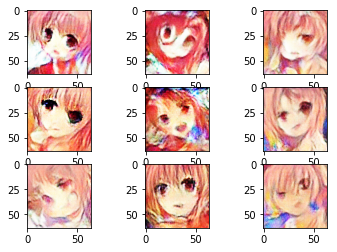

In [180]:
h_i = random.randint(0,12)
e_i = random.randint(0,11)

# show(condition=4,output_str='gan9_bs16_HEclass',k=22,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=4,output_str='gan9_bs16_HEclass_original',k=2,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=4,output_str='gan9_bs16_HEclass_more',k=3,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=4,output_str='gan',k=11,img_n=9,hair_i=h_i,eyes_i=e_i)
show(condition=4,output_str='gan',k=-1,img_n=9,hair_i=h_i,eyes_i=e_i)


# show(condition=3,output_str='gan9_bs16',k=14,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=3,output_str='gan9_bs64_no_hair_gp',k=5,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=4,output_str='gan9_bs32_no_hair_gp_more_negative_example',k=9,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=4,output_str='gan9_bs16_withtag',k=14,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=3,output_str='gan9',k=2,img_n=9,hair_i=h_i,eyes_i=e_i)

# show(condition=True,output_str='gan8',k=0,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=True,output_str='gan8_bs16',k=3,img_n=9,hair_i=h_i,eyes_i=e_i)
# show(condition=False,output_str='gan8_no_condition',k=7,img_n=9,hair_i=h_i,eyes_i=e_i)

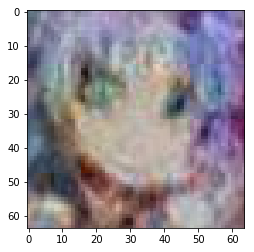

In [152]:
def test_show() :
    k = 2
    output_str = 'first_try'
#     output_str = 'lda20'
#     output_str = 'condition'
    img_temp = skimage.io.imread('img_sample_{}_{}.jpg'.format(output_str,k))
    
    imshow(img_temp)
test_show()

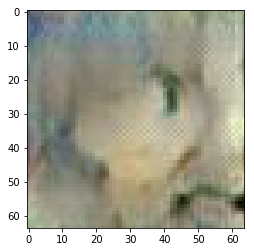

In [44]:
def test_show() :
    k = 3
#     output_str = 'first_try'
#     output_str = 'lda20'
    output_str = 'condition'
    img_temp = skimage.io.imread('img_sample_{}_{}.jpg'.format(output_str,k))
    imshow(img_temp)
test_show()

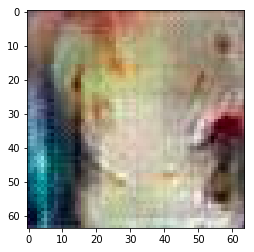

In [45]:
def test_show() :
    k = 0
#     output_str = 'first_try'
#     output_str = 'lda20'
    output_str = 'condition2'
    img_temp = skimage.io.imread('img_sample_{}_{}.jpg'.format(output_str,k))
    imshow(img_temp)
test_show()

In [46]:
def test_show() :
    k = 23
#     output_str = 'first_try'
#     output_str = 'lda20'
    output_str = 'condition'
    img_temp = skimage.io.imread('img_sample_{}_{}.jpg'.format(output_str,k))
    imshow(img_temp)
test_show()

FileNotFoundError: [Errno 2] No such file or directory: 'img_sample_condition_23.jpg'

In [ ]:
def test_show() :
    k = 15
#     output_str = 'first_try'
#     output_str = 'lda20'
    output_str = 'condition_oneone'
    img_temp = skimage.io.imread('img/img_sample_{}_{}.jpg'.format(output_str,k))
    imshow(img_temp)
test_show()